In [1]:

import numpy as np
import pandas as pd
import scipy
from scipy import stats
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats import diagnostic
from scipy.stats import normaltest, boxcox
import math

In [2]:
ny_crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
ny_crime.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [3]:
ny_crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
ny_crime.columns = ny_crime.iloc[3]
ny_crime.drop([0,1,2,3,352,353,354], inplace=True) #drop header and footer info
ny_crime.index = ny_crime['City']

ny_crime['Aggravated\nassault']
# only focus on columns of interest
ny_crime_coi = ny_crime[['Aggravated\nassault','Property\ncrime','Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Larceny-\ntheft']] 

# change column dtypes to numeric
for col in ny_crime_coi:
    ny_crime_coi[col] = pd.to_numeric(ny_crime_coi[col])

# New York is the huge outlier in the data so we'll drop it for the purposes of this exercise
ny_crime_coi.drop('New York', inplace=True)

features = ny_crime_coi[['Property\ncrime','Population']]
features['Population^2'] = features['Population'].apply(lambda x: x**2)
features['Murder_binary'] = np.where(ny_crime_coi['Murder and\nnonnegligent\nmanslaughter']>0,1,0)
features['Robbery_binary'] = np.where(ny_crime_coi['Robbery']>0,1,0)

features.head()

c:\python36-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\python36-32\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:

3,Property crime,Population,Population^2,Murder_binary,Robbery_binary
City,,,,,
Adams Village,12,1861,3463321,0,0
Addison Town and Village,24,2577,6640929,0,0
Akron Village,16,2846,8099716,0,0
Albany,4090,97956,9595377936,1,1
Albion Village,223,6388,40806544,0,1


In [4]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['Property\ncrime']
X = features[['Population','Population^2','Murder_binary','Robbery_binary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])



Coefficients: 
 [  1.29510871e-02   1.14920528e-07   1.95038666e+02   9.28205845e+01]

Intercept: 
 -16.8158663217

R-squared:
0.844493761117

residual normal test now (pval):  2.39544701769e-86

residual homoscedasticity test now (pval):  1.53734156124e-30


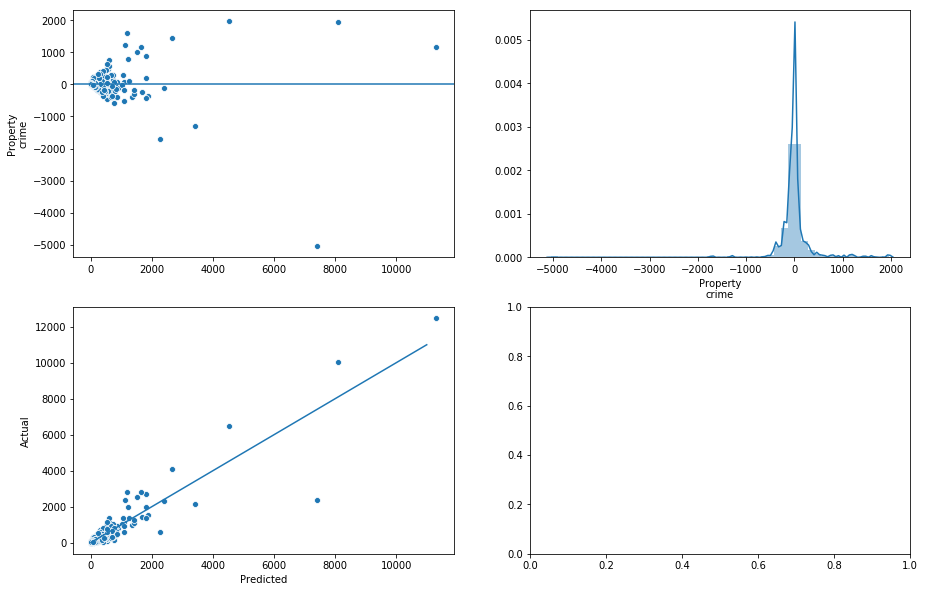

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(predicted, residual, ax=axes[0][0])
axes[0][0].axhline(y=0)
     
sns.distplot(residual, ax=axes[0][1])

sns.scatterplot(predicted, actual, ax=axes[1][0])
axes[1][0].set(xlabel='Predicted', ylabel='Actual')
axes[1][0].plot([0,11000],[0,11000])

NormaltestResult(statistic=1.3376722253908575, pvalue=0.51230449562720226)


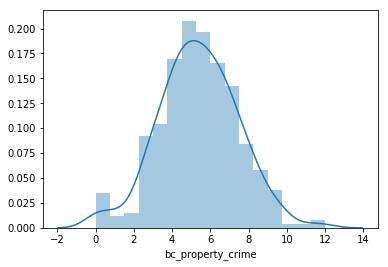

In [6]:
# box cox transformation on bc_property_crime
features['bc_property_crime'] = boxcox(features['Property\ncrime']+1)[0]
box_cox_lambda = boxcox(features['Property\ncrime']+1)[1]

print(normaltest(features['bc_property_crime']))
sns.distplot(features['bc_property_crime'])

In [7]:
def root_transform(series, target):
    ''' finds best (highest r2 value) root transformation for series'''
    pwr=.99
    step = .01
    prev_r2 = -1
    current_r2 = stats.pearsonr(series, target)[0]**2
    
    while prev_r2 < current_r2:        
        prev_r2 = current_r2
        current_r2 = stats.pearsonr(series**pwr, target)[0]**2
        step = .01
        pwr -= step
    pwr += step
    
    return (series**pwr, pwr, prev_r2)

r squared = 0.7596656201239537
power = 0.019999999999999248


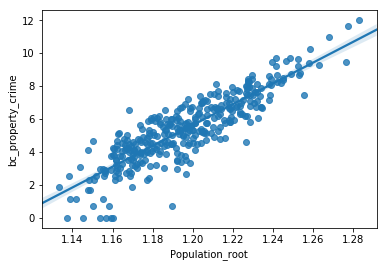

In [8]:
# transform population
features['Population_root'], population_root_pwr, r2 = root_transform(features['Population'], features['bc_property_crime'])
sns.regplot(data=features, x='Population_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, population_root_pwr))

r squared = 0.6961702747463085
power = 0.2099999999999993


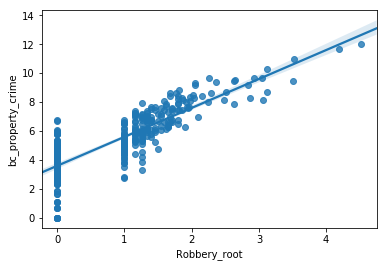

In [9]:
# transform Robbery
features['Robbery_root'], robbery_root_pwr, r2 = root_transform(ny_crime_coi['Robbery'], features['bc_property_crime'])
sns.regplot(data=features, x='Robbery_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, robbery_root_pwr))

r squared = 0.2806463271356509
power = 0.28999999999999937


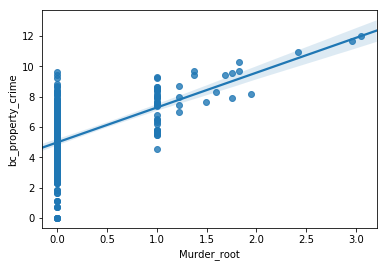

In [10]:
# transform Murder
features['Murder_root'], murder_root_pwr, r2 = root_transform(ny_crime_coi['Murder and\nnonnegligent\nmanslaughter'], features['bc_property_crime'])
sns.regplot(data=features, x='Murder_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, murder_root_pwr))

r squared = 0.6737809677414435
power = 0.23999999999999932


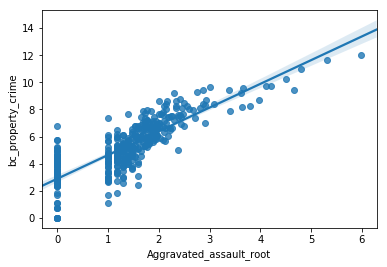

In [11]:
# transform Aggravated assault
features['Aggravated_assault_root'], aggravated_assault_root_pwr, r2 = root_transform(ny_crime_coi['Aggravated\nassault'], features['bc_property_crime'])
sns.regplot(data=features, x='Aggravated_assault_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, aggravated_assault_root_pwr))

In [12]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['bc_property_crime']
X = features[['Population_root','Murder_root','Robbery_root','Aggravated_assault_root']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])



Coefficients: 
 [ 34.62934923  -0.37982439   0.68644238   0.61967315]

Intercept: 
 -37.4634136883

R-squared:
0.847617929129

residual normal test now (pval):  3.89051351808e-09

residual homoscedasticity test now (pval):  1.137810661e-13


In [13]:
X.corr()

3,Population_root,Murder_root,Robbery_root,Aggravated_assault_root
3,,,,
Population_root,1.000000,0.531064,0.776122,0.749043
Murder_root,0.531064,1.000000,0.620757,0.638709
Robbery_root,0.776122,0.620757,1.000000,0.795487
Aggravated_assault_root,0.749043,0.638709,0.795487,1.000000


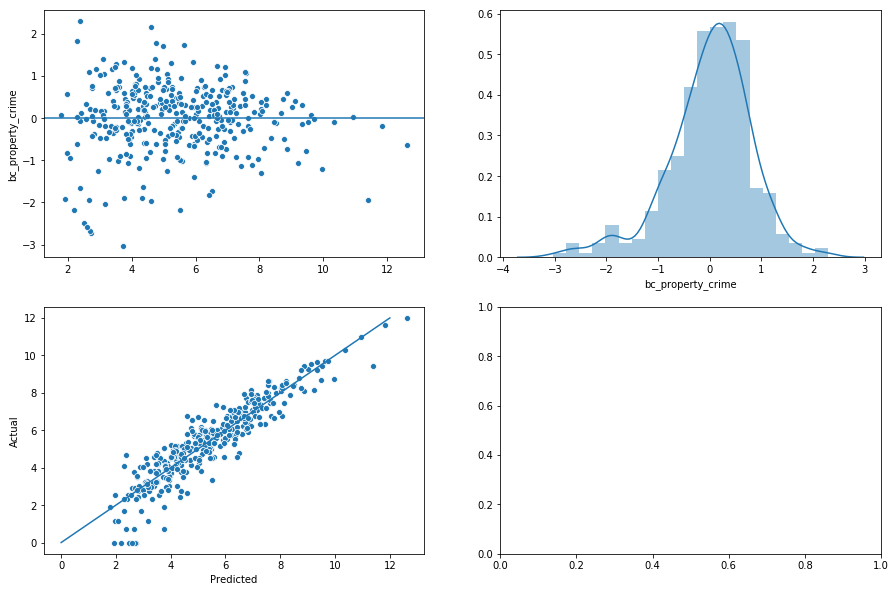

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(predicted, residual, ax=axes[0][0])
axes[0][0].axhline(y=0)
     
sns.distplot(residual, ax=axes[0][1])

sns.scatterplot(predicted, actual, ax=axes[1][0])
axes[1][0].set(xlabel='Predicted', ylabel='Actual')
axes[1][0].plot([0,12],[0,12])

## Feature engineering overview

### Original Model:
    - Predicted value: 
        - Property Crime
    - Features: 
        - Population
        - Population (squared)
        - Murder (binary)
        - Robbery (binary)

### New Model:
    - Predicted value : 
        - Property Crime (box cox transformed)
    - Features : 
        - Population (root transformed)
        - Murder (root transformed
        - Robbery (root transformed)
        - Aggravated assault (root transformed)


The new model applied a box cox transformation to the predicted values in order to achieve more normally distributed predicted values. The new model took the three base features from the original model (population, murder, robbery) and applied the root transformation that resulted in the most explained variance when regressed against the predicted value. Aggravated assault was also root transformed and added as a feature. The new model resulted in only a small increase in explained variance, but its residuals were both more normally distributed and more homoscedastic.